In [1]:
import matplotlib.pyplot as plt
import matplotlib.ticker as tck
import numpy as np
import scipy.signal as signal
plt.rcParams.update({'font.size': 15})

from LMS_ecg import LMS

*The second exam deals with adaptive filters. Your job is to investigate an adaptive filtering problem and write a small report in the style of a laboratory journal. You will need to include a theoretical background, explain your choice and settings of the adaptive algorithm(s), perform numerical experiments and finally present, analyze and discuss the results. You can use one of the five exercises from the class as the starting point, but you are also free to pick your own problem to work from.*

# Adaptive line enhance for noisy ECG signals using LMS
I am given a noise data set, from an ECG measurement, and will try to purify it. First, we investigate the polluted signals spectrum.


## Load noisy data file and find noise frequency

In [52]:
def load_data(path):
    with open(path) as data:
        out = data.readlines()

    return [float(x) for x in out]

In [3]:
path = './ecg.txt'
sample_rate = 500  # Hz
ecg_data = np.array(load_data(path))
ecg_data /= np.max(ecg_data)

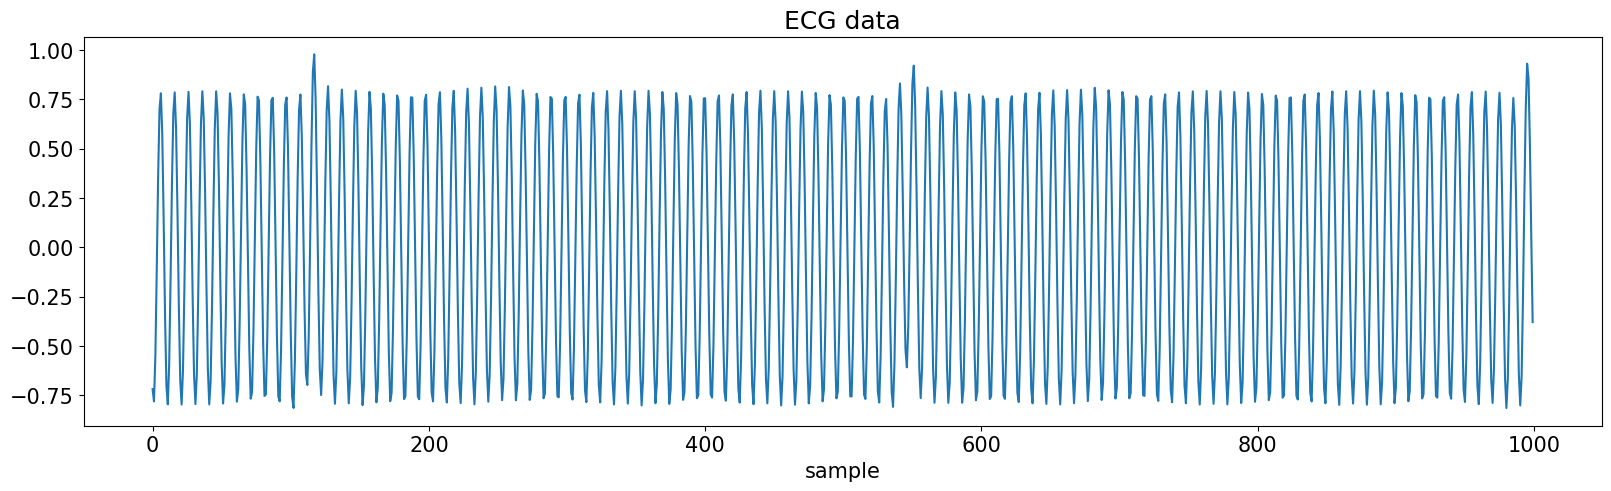

In [4]:
fig, ax = plt.subplots(constrained_layout=True)
fig.set_figwidth(16)
ax.set_xlabel('sample')

ax.set_title('ECG data')
ax.plot(ecg_data[:1000])
plt.show()

To remove the power line noise, I use an LMS based algorithm, trying to cancel the noise with a power line frequency signal. To find this noise frequency we estimate the PSD using Bartlett and Welch's method.

In [5]:
_, ecg_spectrum = signal.welch(ecg_data, fs=sample_rate,nperseg=512)
norm_frequencies = np.linspace(0,1,len(ecg_spectrum))  # in units of pi

Assuming a gaussian peak **Later replace with gaussian fit**

In [6]:
peak = np.argmax(ecg_spectrum)

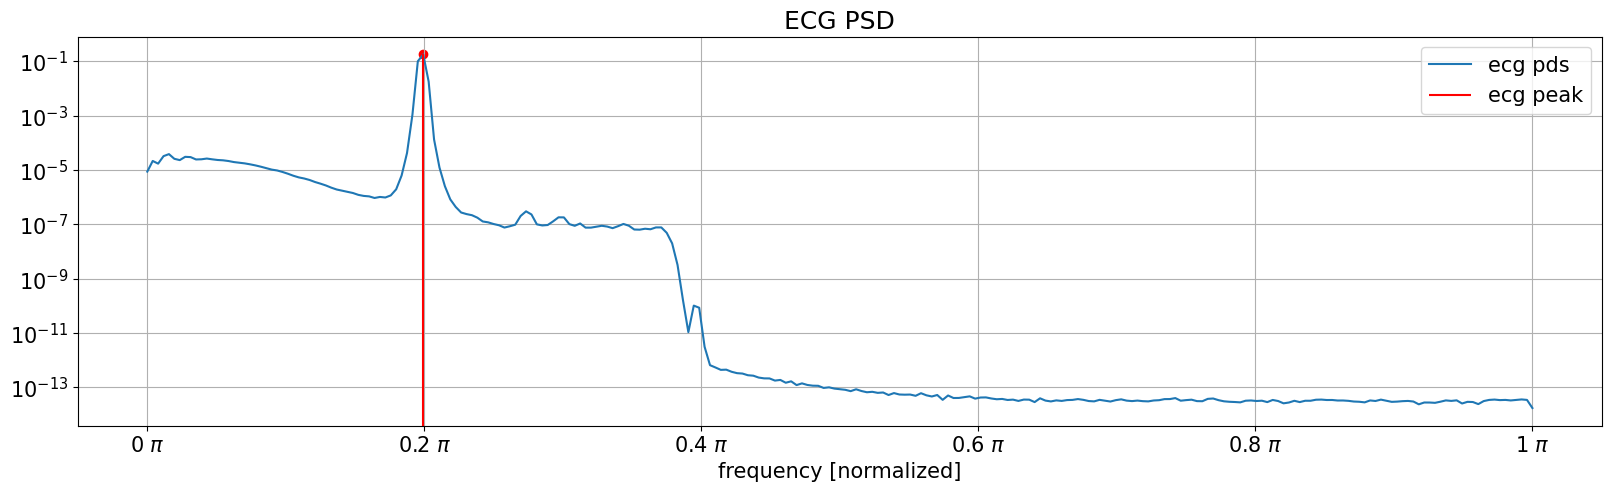

In [7]:
fig, ax = plt.subplots(constrained_layout=True)
fig.set_figwidth(16)
ax.set_xlabel('frequency [normalized]')

ax.set_title('ECG PSD')
ax.semilogy(norm_frequencies, ecg_spectrum, label='ecg pds')
ax.vlines(norm_frequencies[peak], ymin=0, ymax=ecg_spectrum[peak], colors='r', label='ecg peak')
ax.scatter((norm_frequencies[peak],), (ecg_spectrum[peak],), c='r')

ax.xaxis.set_major_formatter(tck.FormatStrFormatter('%g $\pi$'))
plt.grid()
plt.legend()
plt.show()

In [8]:
noise_frequency = norm_frequencies[peak]
print(f'Noisy central frequency, f_noise = {noise_frequency} pi = {noise_frequency*sample_rate/2} Hz', )

Noisy central frequency, f_noise = 0.19921875 pi = 49.8046875 Hz


This matches the expectation of a powerline frequency of around 50 Hz

## ALE setup
It is basically an M-step-ahead predictor. The assumption is that the noise samples, which are more than M samples apart, are uncorrelated with one another. As a result, the predictor can only make a prediction of the sinusoidal components of the input signal and when adapted to minimize the output MSE, the line enhancer will be a filter tuned to the sinusoidal components. The maximum possible rejection of the noise will also be achieved as any portion of the noise, which passes through the prediction filter, will enhance the output MSE whose minimization is the criterion in adapting the filter tap weights.

![ALE_problem](img/ALE_problem.png)


## delay
To remove this noise component we set up an adaptive line enhancer. For this we firstly need a signal delayer

In [9]:
def signal_delay(signal, delay_taps):
    delayed_signal = np.zeros(signal.shape)
    delayed_signal[delay_taps:] = signal[:-delay_taps]
    return delayed_signal

# LMS
Finally, we initiate the LMS adaptive filter algorithm

In [40]:
delay = 1  # start with assuming white noise
step_size = 0.001  # guess small steps
filter_taps = 3  # small filter to start with
weights = np.zeros(filter_taps)

ale = LMS(signal_delay(ecg_data, delay), ecg_data,weights, step_size)

In [41]:
weights = ale.adapt_weights()

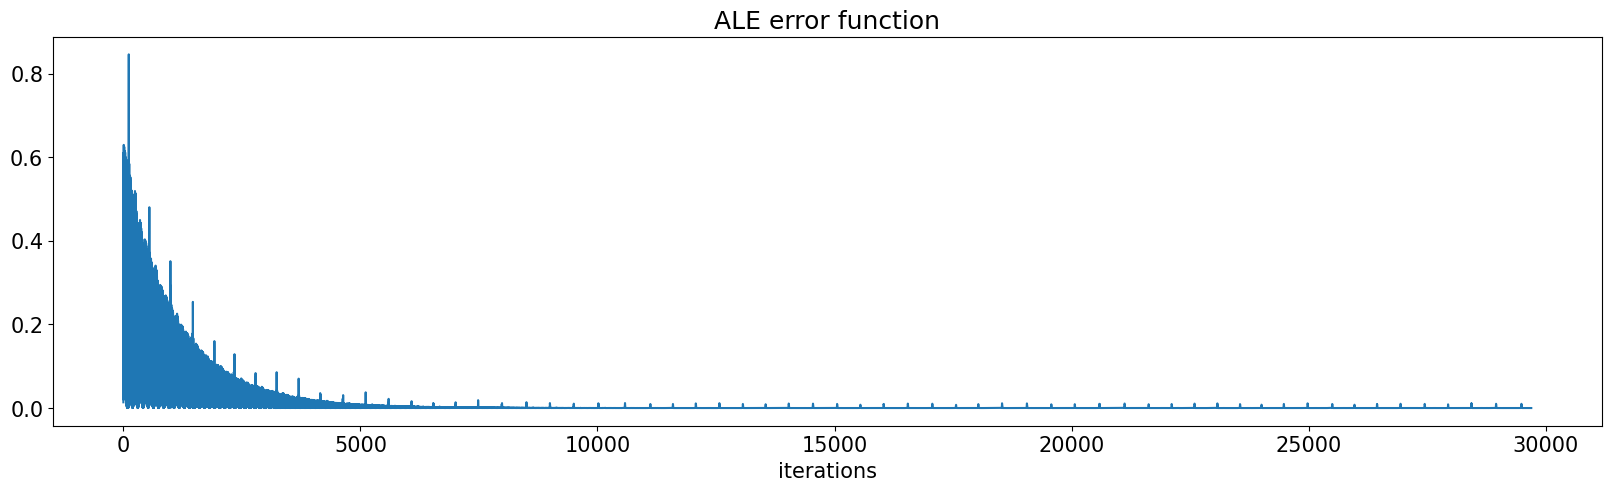

In [42]:
fig, ax = plt.subplots(constrained_layout=True)
fig.set_figwidth(16)
ax.set_xlabel('iterations')

ax.set_title('ALE error function')
ax.plot(ale.error**2)

plt.show()

## Resulting filter

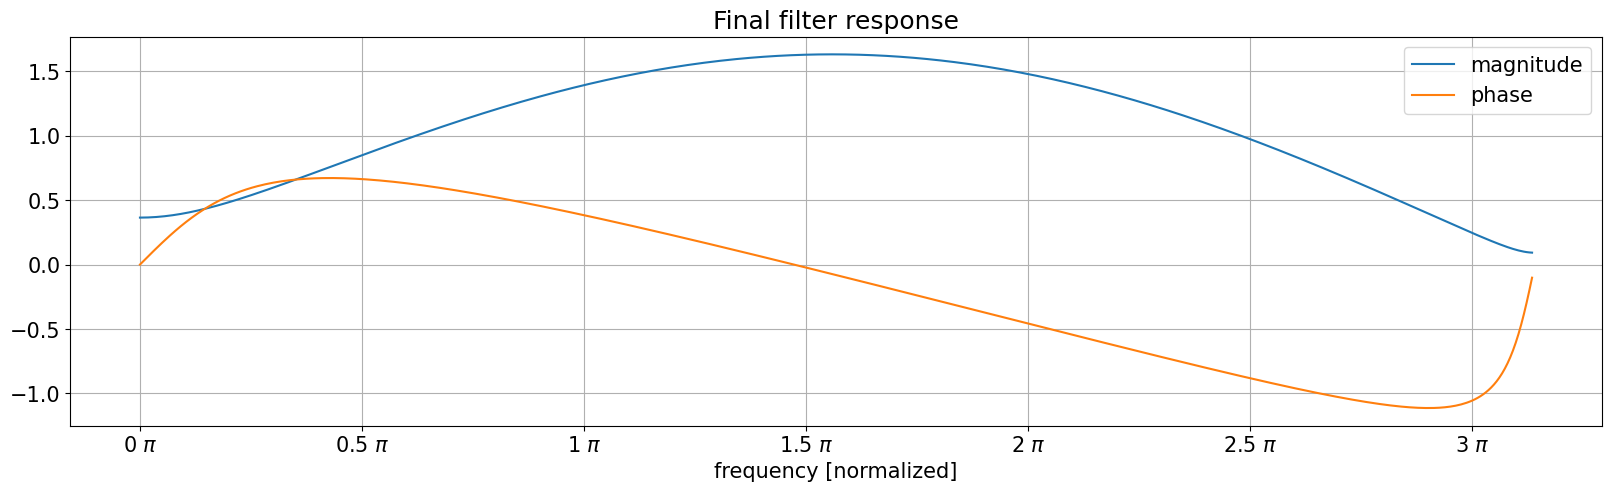

In [43]:
freq, filt_rsp = signal.freqz(weights)

fig, ax = plt.subplots(constrained_layout=True)
fig.set_figwidth(16)
ax.set_xlabel('frequency [normalized]')

ax.set_title('Final filter response')
ax.plot(freq, np.abs(filt_rsp), label='magnitude')
ax.plot(freq, np.angle(filt_rsp), label='phase')

ax.xaxis.set_major_formatter(tck.FormatStrFormatter('%g $\pi$'))
plt.grid()
plt.legend()
plt.show()

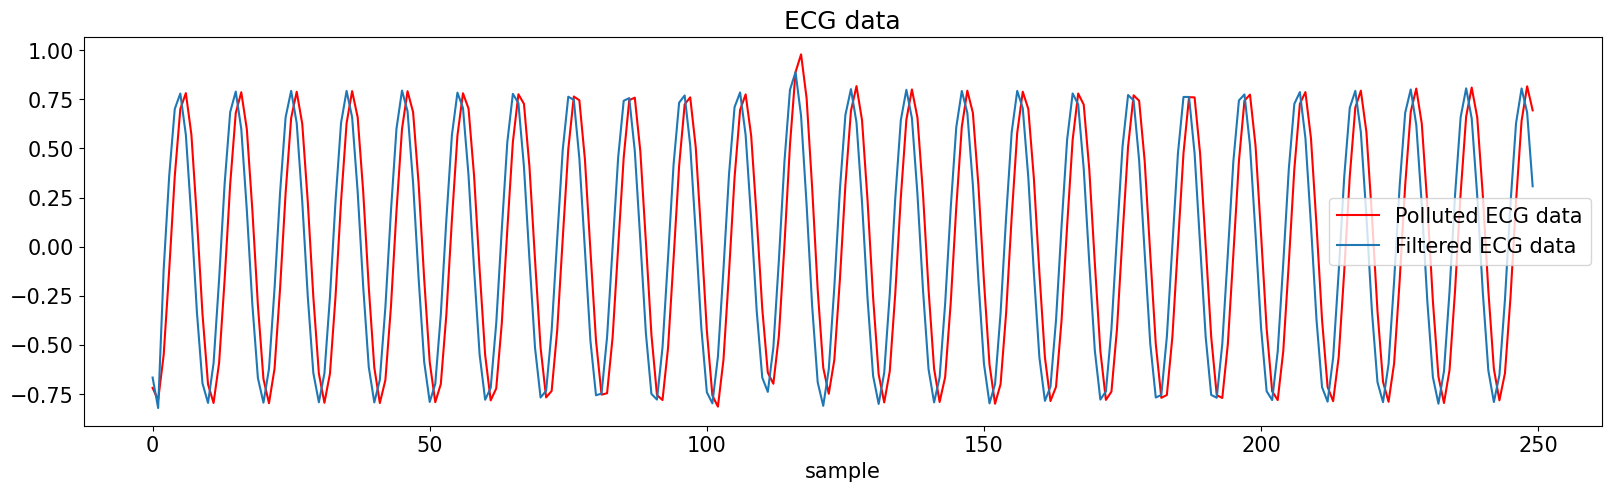

In [44]:
filtered_ecg = signal.lfilter(weights, [1], ecg_data)
fig, ax = plt.subplots(constrained_layout=True)
fig.set_figwidth(16)
ax.set_xlabel('sample')

ax.set_title('ECG data')
ax.plot(ecg_data[:250], 'r', label='Polluted ECG data')
ax.plot(filtered_ecg[:250], label='Filtered ECG data')

plt.legend()
plt.show()

## Filtered spectrum


In [45]:
_, filtered_ecg_spectrum = signal.welch(filtered_ecg, fs=sample_rate,nperseg=512)
norm_frequencies = np.linspace(0,1,len(ecg_spectrum))  # in units of pi

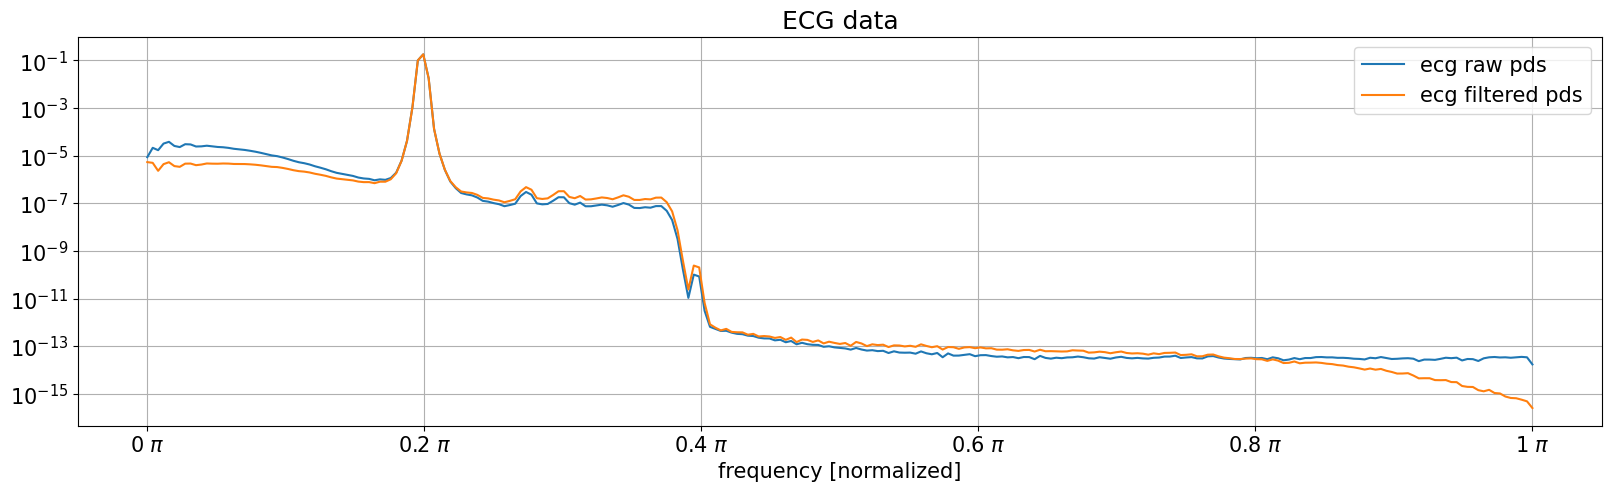

In [46]:
fig, ax = plt.subplots(constrained_layout=True)
fig.set_figwidth(16)
ax.set_xlabel('frequency [normalized]')

ax.set_title('ECG data')
ax.semilogy(norm_frequencies, ecg_spectrum, label='ecg raw pds')
ax.semilogy(norm_frequencies, filtered_ecg_spectrum, label='ecg filtered pds')


ax.xaxis.set_major_formatter(tck.FormatStrFormatter('%g $\pi$'))
plt.grid()
plt.legend()
plt.show()


In [48]:
test = {'a': 10}

In [50]:
'a' in test

True

In [51]:
np.sum?